In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/overnight-hackathon/Test_Data.csv
/kaggle/input/overnight-hackathon/Train_Images/Train_Images/IMG_24111_FI_F_15.png
/kaggle/input/overnight-hackathon/Train_Images/Train_Images/IMG_8632_HI_F_18.jpg
/kaggle/input/overnight-hackathon/Train_Images/Train_Images/IMG_2616_HI_F_29.jpg
/kaggle/input/overnight-hackathon/Train_Images/Train_Images/IMG_16192_FI_M_33.jpg
/kaggle/input/overnight-hackathon/Train_Images/Train_Images/IMG_18600_FI_M_22.png
/kaggle/input/overnight-hackathon/Train_Images/Train_Images/IMG_3686_HI_M_26.jpg
/kaggle/input/overnight-hackathon/Train_Images/Train_Images/IMG_12535_FI_M_32.jpg
/kaggle/input/overnight-hackathon/Train_Images/Train_Images/IMG_1449_FI_M_36.jpg
/kaggle/input/overnight-hackathon/Train_Images/Train_Images/IMG_3370_HI_F_26.jpg
/kaggle/input/overnight-hackathon/Train_Images/Train_Images/IMG_29264_HI_M_28.jpg
/kaggle/input/overnight-hackathon/Train_Images/Train_Images/IMG_13291_FI_M_27.bmp
/kaggle/input/overnight-hackathon/Train_Images/Train_Im

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
from pathlib import Path
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input,BatchNormalization

In [228]:
BASE_DIR = Path("../input/overnight-hackathon/Train_Images/Train_Images")

In [229]:
filepaths = pd.Series(list(BASE_DIR.glob(r'**/*.jpg')),name='Filepaths').astype(str)

In [230]:
ages = pd.Series(filepaths.apply(lambda x: os.path.split(x)[1].split('_')[-1].split('.')[0]),name='Age').astype(np.int)


In [231]:
df = pd.concat([filepaths,ages],axis=1).sample(frac=1.0,random_state=1).reset_index(drop=True)

In [232]:
df.head()

Filepaths  Age
0  ../input/overnight-hackathon/Train_Images/Trai...   26
1  ../input/overnight-hackathon/Train_Images/Trai...   29
2  ../input/overnight-hackathon/Train_Images/Trai...   26
3  ../input/overnight-hackathon/Train_Images/Trai...   31
4  ../input/overnight-hackathon/Train_Images/Trai...   42

In [200]:
from sklearn.model_selection import train_test_split

In [233]:
train_set, test_set = train_test_split(df,test_size=0.1,random_state=42)

In [235]:
# from PIL import Image
# img = Image.open(df['Paths'][100])
# plt.axis('off')
# plt.imshow(img);

In [236]:
import seaborn as sns

<AxesSubplot:xlabel='Age', ylabel='Density'>

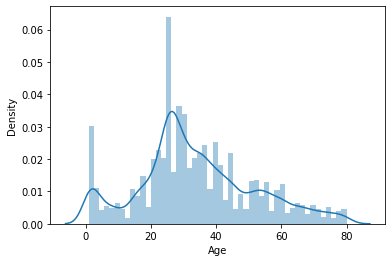

In [237]:
sns.distplot(df['Age'])

In [238]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [241]:
train = train_gen.flow_from_dataframe(dataframe= train_set,x_col="Filepaths",y_col="Age",
                                      target_size=(120,120),
                                      color_mode='rgb',
                                      class_mode="raw", 
                                      batch_size=32,
                                      shuffle=False,
                                      subset = "training",
                                      seed = 42
                                     )
test = test_gen.flow_from_dataframe(dataframe= test_set,x_col="Filepaths", y_col=None,
                                     target_size=(120,120),
                                     color_mode='rgb',
                                     class_mode=None,
                                     batch_size=32,
                                     shuffle= False,
                                    )
val = train_gen.flow_from_dataframe(dataframe= train_set,x_col="Filepaths", y_col="Age",
                                    target_size=(120,120),
                                     color_mode='rgb',
                                     class_mode="raw",
                                     batch_size=32,
                                     shuffle= False,
                                    subset = "validation",
                                    seed = 42
                                   )

Found 16489 validated image filenames.
Found 2291 validated image filenames.
Found 4122 validated image filenames.


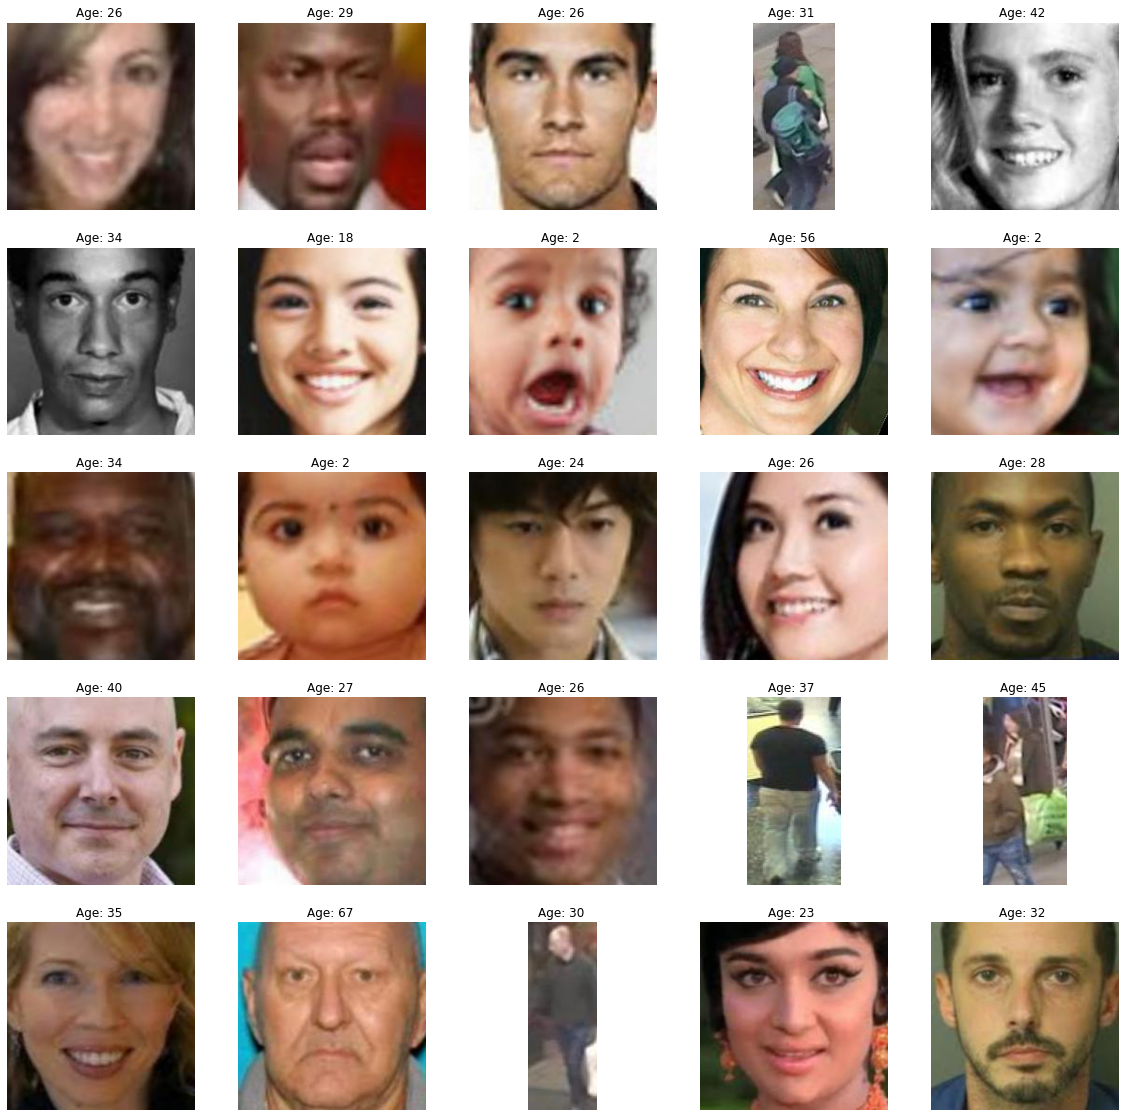

In [242]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} ")
    plt.axis('off')

In [243]:
input_shape = (120, 120, 3)

In [271]:
inputs = Input((input_shape))
conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu') (inputs)
max_p1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(32, kernel_size=(3, 3), activation='relu') (max_p1)
max_p2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu') (max_p2)
max_p3 = MaxPooling2D(pool_size=(2, 2))(conv3)

x = tf.keras.layers.GlobalAveragePooling2D()(max_p3) #better than flatten

#flatten = Flatten()(x)


# dense3 = Dense(1,activation='softmax')(dense1)
x = Dense(128,activation='relu')(x)
x= Dropout(0.3)(x)
x = Dense(128,activation='relu')(x)
outputs = Dense(1,activation='linear')(x)
model =Model(inputs=inputs, outputs=outputs)

model.compile(loss='mse', optimizer='adam')


In [272]:
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 118, 118, 16)      448       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 59, 59, 16)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 57, 57, 32)        4640      
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 13, 13, 64)        0  

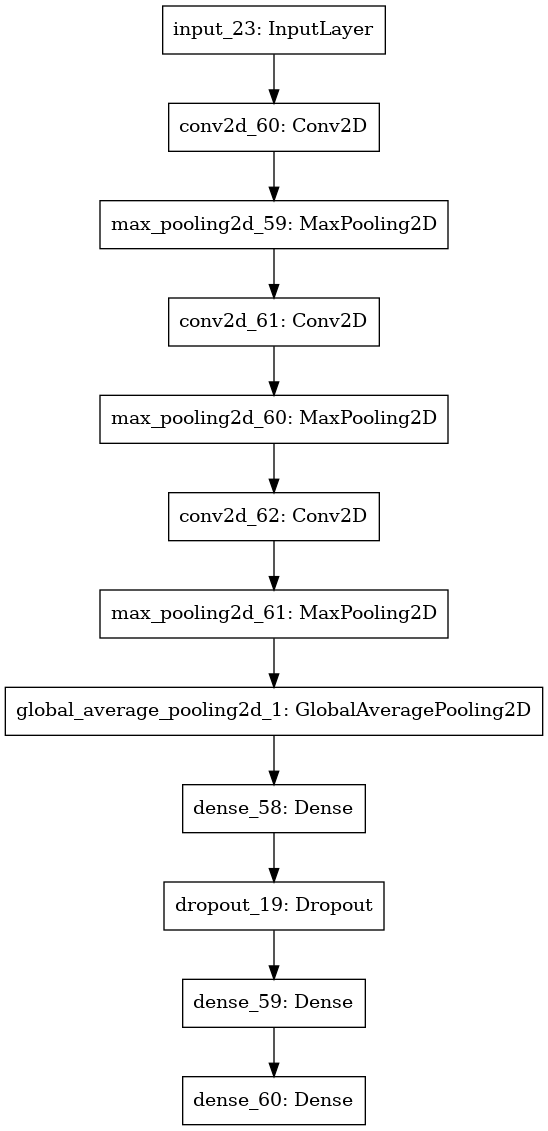

In [273]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [274]:
history = model.fit(train, validation_data=val, batch_size=32, epochs=10,
                   callbacks =[tf.keras.callbacks.EarlyStopping(
                   monitor='val_loss',
                   patience=5,
                   restore_best_weights=True)])

Epoch 1/10
516/516 [==============================] - 74s 141ms/step - loss: 387.9566 - val_loss: 303.8624
Epoch 2/10
516/516 [==============================] - 72s 140ms/step - loss: 313.6678 - val_loss: 300.1700
Epoch 3/10
516/516 [==============================] - 72s 139ms/step - loss: 303.7860 - val_loss: 307.9238
Epoch 4/10
516/516 [==============================] - 72s 139ms/step - loss: 305.7670 - val_loss: 305.8486
Epoch 5/10
516/516 [==============================] - 72s 140ms/step - loss: 299.5395 - val_loss: 292.7780
Epoch 6/10
516/516 [==============================] - 72s 140ms/step - loss: 295.6955 - val_loss: 288.1878
Epoch 7/10
516/516 [==============================] - 72s 140ms/step - loss: 290.2951 - val_loss: 281.0457
Epoch 8/10
516/516 [==============================] - 72s 140ms/step - loss: 285.8180 - val_loss: 281.2473
Epoch 9/10
516/516 [==============================] - 72s 140ms/step - loss: 275.2343 - val_loss: 263.4159
Epoch 10/10
516/516 [================

In [275]:
predicted_ages  = np.squeeze(model.predict(val))
true_ages = val.labels

rmse = np.sqrt(model.evaluate(val,verbose=0))
print(rmse)


15.75669403721548


In [276]:
final = pd.read_csv("../input/overnight-hackathon/Test_Data.csv")

In [277]:
final

img_file
0       IMG_10000_HI_M.jpg
1       IMG_10001_FI_F.jpg
2       IMG_10002_FI_F.jpg
3       IMG_10003_FI_F.jpg
4      IMG_10004_FI_M.jpeg
...                    ...
12637    IMG_9998_HI_M.jpg
12638    IMG_9999_FI_F.jpg
12639     IMG_999_HI_F.jpg
12640      IMG_99_HI_M.jpg
12641       IMG_9_HI_M.jpg

[12642 rows x 1 columns]

In [278]:
final_path = "../input/overnight-hackathon/Test_Image/Test_Image"

In [279]:
final_images = test_gen.flow_from_dataframe(
dataframe=final,
directory = final_path,
x_col = 'img_file',
y_col = None,
target_size=(120,120),
color_mode='rgb',
class_mode=None,
batch_size=32,
shuffle=False,
seed=42,
verbose=1
)

Found 12642 validated image filenames.


In [ ]:
y = pd.Series(np.squeeze(model.predict(final_images)),name='age').astype(np.int)
ans = pd.concat([final,y],axis=1)
ans.to_csv("results.csv",index=False)